### Fig. 2 | A multivariate model classifying and predicting different pain conditions. ###
We run the analyses for both the model representation and model evaluation.


A. Model Representation
1. Explained variance in Pain Sites across Domains and Unions
2. Explained variance in Pain Sites across Categories
3. Permutation for the the least contributing category.


B. Model Evaluation
1. Model fit with Number of Pain Sites
2. Group comparison between pain sites and pain-free participants.
3. Discrimination AUC-ROC for those same comparisons.

In [1]:
#### Import Libraries ####
import numpy as np
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
from scipy import stats
from sklearn import cross_decomposition, model_selection, linear_model, metrics
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import nltools
import math
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
plt.rcParams['font.size'] = 8
sns.set(font="Arial", style = 'white')
Folder = '/Users/Chris/Script_folder/'

In [2]:
# Loading all data
variables, W = pd.read_csv(Folder + '0_Variables_V3.csv'), pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables = variables[variables.coding_finished==1]
variables_T0 = list((variables['Name'] + '_' + variables['T0']).values)
variables['weights'] = W.Coefficients.values

# Computing risk score (Partial Least Square)
preproc_UKB_Test = pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv')
preproc_UKB_Test['PLS'] =  np.dot(preproc_UKB_Test[variables_T0], variables['weights'])

# Color dictionnary
dico_col = dict(zip(variables.Category.unique(),sns.color_palette("nipy_spectral_r", n_colors = len(variables.Category.unique())))) #Color list
color_list = []
for i in variables.Category: color_list.append(dico_col[i])
variables['color'] = color_list

In [3]:
# Subset of participants without pain all over the body
T2_noWP = preproc_UKB_Test[preproc_UKB_Test.WidespreadPainLastMonth_T0!=1]
Y_T2 = T2_noWP['NumberPainTypesLastMonth_T0']

In [4]:
# Create function for variance explained for each dimension
def venn_score(dim, equal = True):
    if dim == 'All': df = variables; # Full Model
    else:
        if equal == True: df = variables[variables.Dimension==dim]; #Each Domain seperately
        elif equal == False: df = variables[variables.Dimension!=dim]; #Union of Domains by excluding the third one
    return(int(np.round(np.corrcoef(np.dot(T2_noWP[df['Name'] + '_T0'], df['weights']), Y_T2)[0][1]**2*100)))
A, B, C = venn_score('MentalHealth', equal = True), venn_score('PhysicalHealth', equal = True), venn_score('Sociodemographic', equal = True)
AB, AC, BC, ABC = venn_score('Sociodemographic', equal = False), venn_score('PhysicalHealth', equal = False), venn_score('MentalHealth', equal = False), venn_score('All')

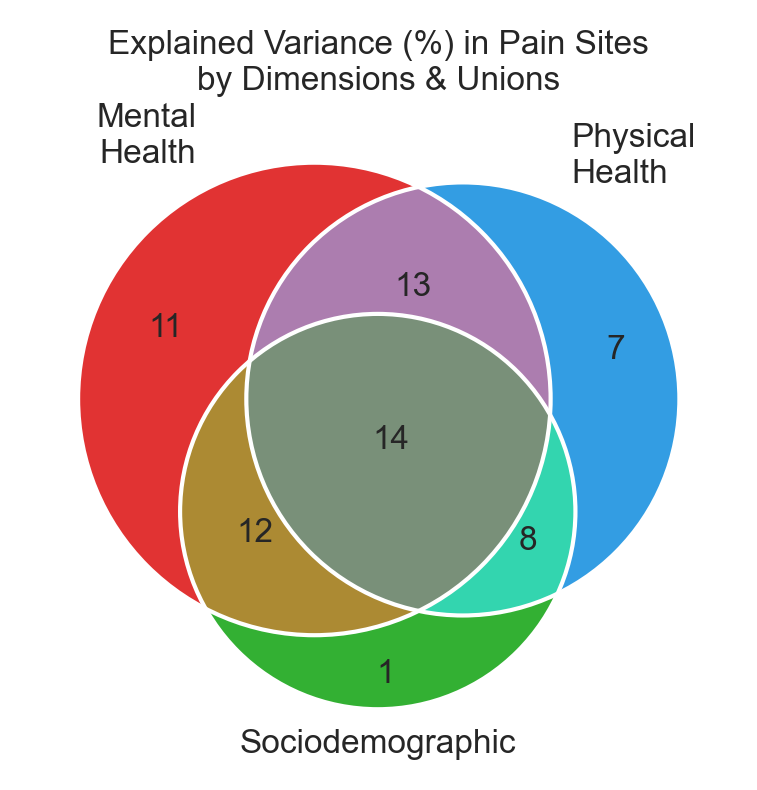

In [5]:
#### FIGURE A.1. Explained Variance across Domains and Union using a Venn Diagraam
fig, axs = plt.subplots(figsize=(3, 3))
v = venn3(ax=axs, subsets = (A, B, AB, C, AC, BC, ABC), set_labels = ('Mental\nHealth', 'Physical\nHealth', 'Sociodemographic'), set_colors=(dico_col['Neuroticism'], dico_col['Sleep'], dico_col['Socioeconomic']), alpha=0.8) #.get_patch_by_id('111').set_color('grey')
c = venn3_circles(ax=axs, subsets = (A, B, AB, C, AC, BC, ABC), linewidth=1, color = 'white')
axs.set_title('Explained Variance (%) in Pain Sites\nby Dimensions & Unions', fontdict={'fontsize': 8})
for text in v.set_labels: text.set_fontsize(8)
for text in v.subset_labels: text.set_fontsize(8)

In [45]:
# Explained Variance for each category 
list_category, list_category_p = [], []
categories = ['Neuroticism', 'Mood', 'Traumas', 'Demographics', 'Occupational', 'Socioeconomic', 'SubstanceUse', 'Sleep', 'Anthropometric', 'PhysicalActivity']
for i in categories:
    df = variables[variables.Category==i]
    corr = stats.pearsonr(np.dot(T2_noWP[df['Name'] + '_T0'], df['weights']), Y_T2) #Dot product with the selected weights, and compute correlation
    list_category.append(corr[0]**2), list_category_p.append(corr[1]) #Note that in training, all p=0 (due to large N)
s_categories = pd.Series(list_category, index = ['Neuroticism', 'Mood', 'Traumas', 'Demographics', 'Occupational', 'Socioeconomic', 'SubstanceUse', 'Sleep', 'Anthropometric', 'PhysicalActivity'])
s_cat = ['Occupational', 'Demographics', 'Socioeconomic', 'PhysicalActivity','SubstanceUse', 'Anthropometric', 'Traumas', 'Neuroticism', 'Sleep','Mood'] #Ranked according to training results
s_categories = s_categories[s_cat]



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


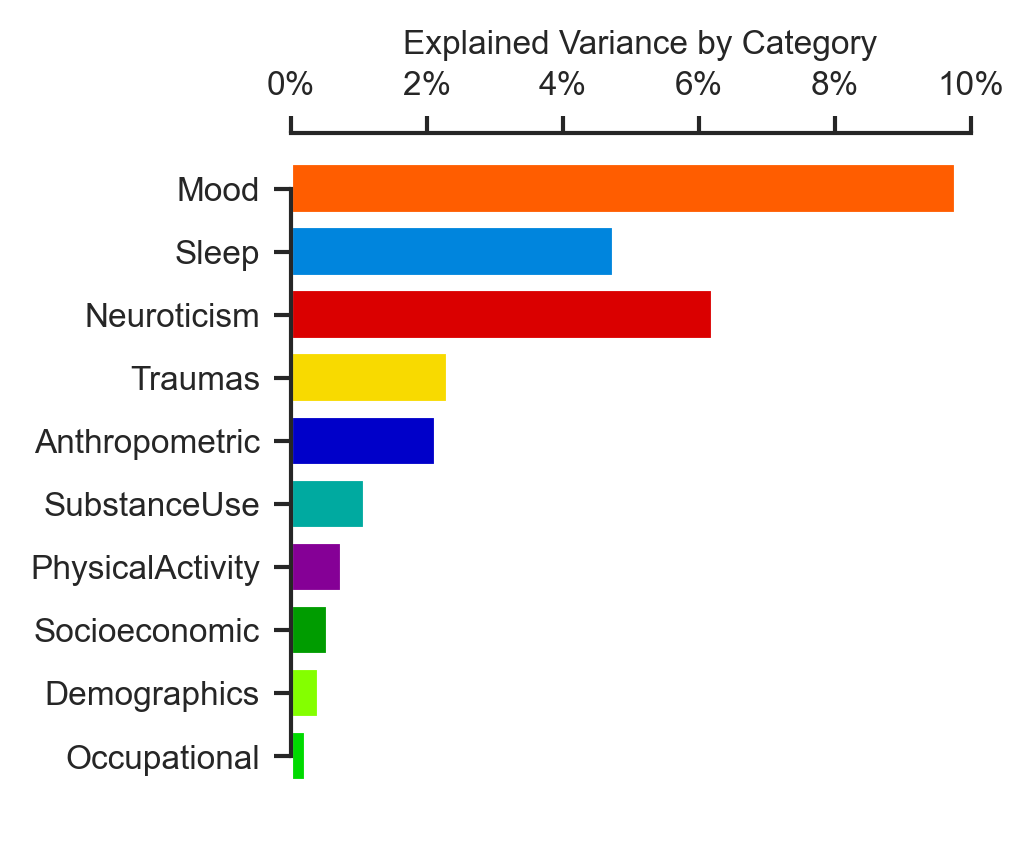

In [46]:
#### FIGURE A.2. Explained Variance by Categories ####
color_sorted = [variables[variables.Category==i]['color'].unique()[0] for i in s_cat]
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(3, 3))
axs.barh(y = s_categories.index, width=s_categories.values, color = color_sorted)
axs.set_xlabel('Explained Variance by Category', fontsize = 8), axs.set_yticklabels(s_categories.index, fontsize = 8)
axs.set_xticks(np.arange(0, 0.11, 0.02)), axs.set_xticklabels(['0%', '2%', '4%', '6%', '8%', '10%'], fontsize = 8)
axs.xaxis.set_label_position('top'), axs.xaxis.tick_top()
axs.spines[['right', 'bottom']].set_visible(False), axs.tick_params(left=True, top = True, length=4, width=1)
axs.spines['top'].set_bounds((0.0,0.10)), axs.spines['left'].set_bounds((0,9))
axs.spines[['top', 'left']].set_linewidth(1)

In [47]:
# Compute permutation for the lowest category (i.e. Occupational).
df = variables[variables.Category=='Occupational']
Occup_score = np.dot(T2_noWP[df['Name'] + '_T0'], df['weights'])
Occup_perm = nltools.stats.correlation_permutation(Occup_score, Y_T2, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=True, random_state=0) 
Occup_df = pd.DataFrame(Occup_perm)

Text(0.5, 0, 'Null Correlations\n(Occupational)')

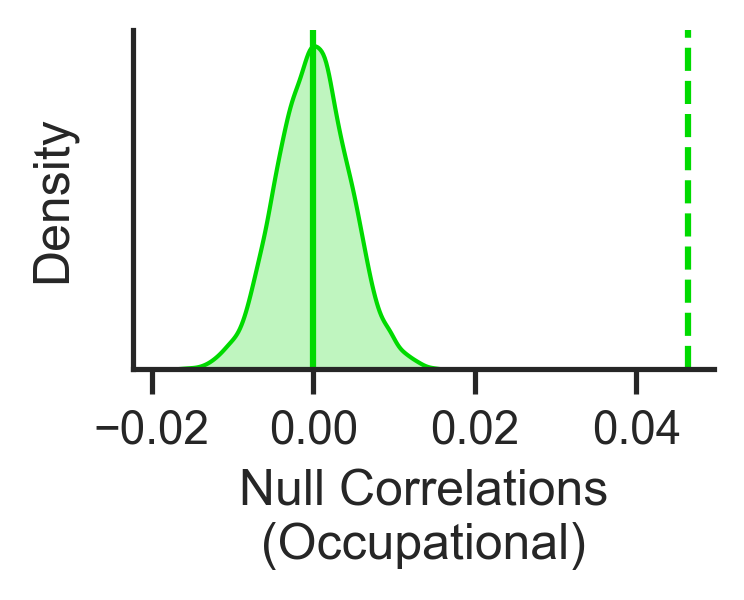

In [63]:
#### FIGURE A.3. Permutation for Occupational Score ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(2.5, 1.5))
sns.kdeplot(ax = axs, data = Occup_df, x = 'perm_dist', fill=True, color = color_sorted[0])
axs.axvline(x = Occup_df['perm_dist'].mean(), color =  color_sorted[0])
axs.axvline(x = Occup_df.correlation.median(), color =  color_sorted[0], ls = '--')
axs.spines[['top', 'right']].set_visible(False), axs.tick_params(bottom=True)
axs.set_ylabel('Density'), axs.set_yticklabels([]) 
axs.set_xticks(np.arange(-0.02,0.06,0.02))
axs.set_xlabel('Null Correlations\n(Occupational)')

In [49]:
#Compute model fit on the testing for the chronic and acute site (model derived on acute and chronic combined on training)
olspred_cp, olspred_ap = sm.OLS(T2_noWP.NumberChronicPainTypes_T0, T2_noWP.PLS).fit().predict(T2_noWP.PLS), sm.OLS(T2_noWP.NumberAcutePainTypes_T0, T2_noWP.PLS).fit().predict(T2_noWP.PLS)
rmse_cp, rmse_ap = math.sqrt(np.square(np.subtract(Y_T2,olspred_cp)).mean()), math.sqrt(np.square(np.subtract(Y_T2,olspred_ap)).mean()) 
r2_cp, r2_ap = T2_noWP.NumberChronicPainTypes_T0.corr(T2_noWP.PLS)**2, T2_noWP.NumberAcutePainTypes_T0.corr(T2_noWP.PLS)**2
print('Chronic, R2:', r2_cp, ', RMSE:', rmse_cp)
print('Acute, R2:', r2_ap, ', RMSE:', rmse_ap)

Chronic, R2: 0.11805589646692201 , RMSE: 1.5291683078016785
Acute, R2: 0.02361355390420284 , RMSE: 1.533528636125738


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


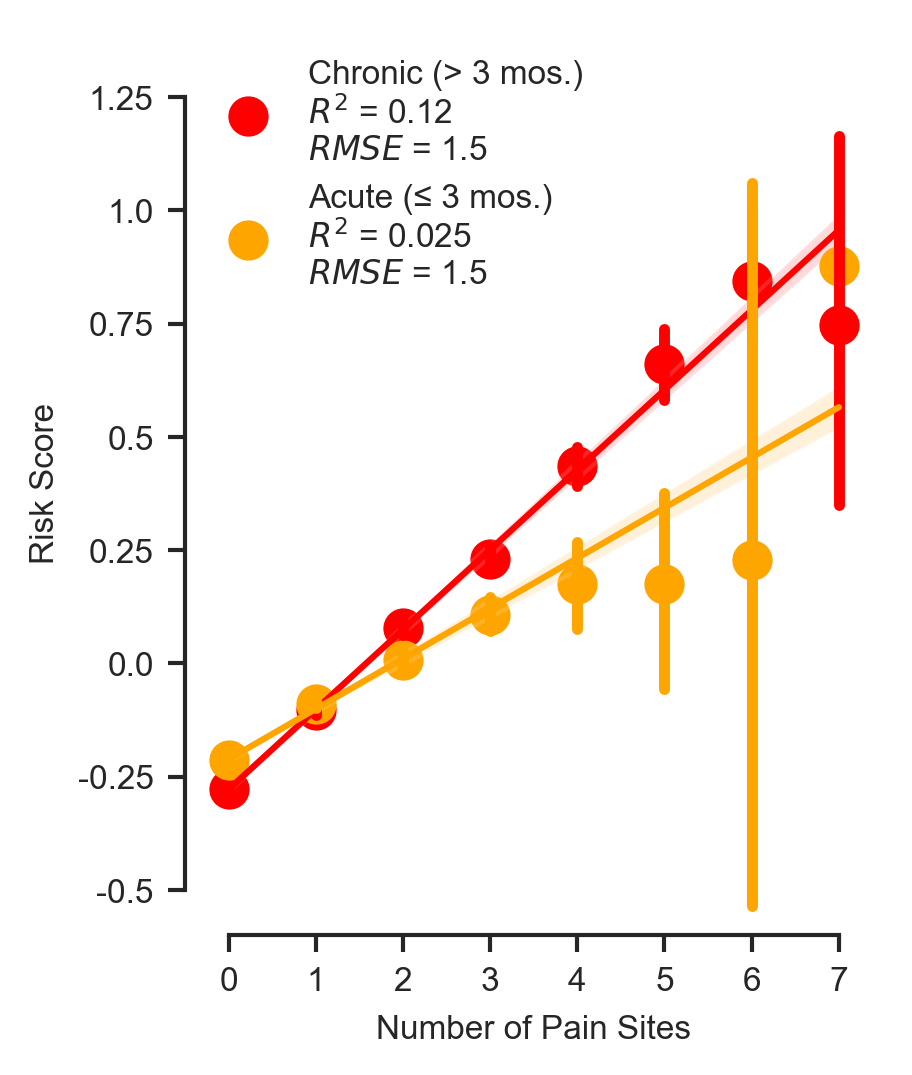

In [62]:
#### FIGURE B.1. Model fit for the PLS ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(3, 4))
sns.regplot(ax = axs, data = T2_noWP, n_boot=500,  x_estimator=np.mean, x = 'NumberChronicPainTypes_T0', y = 'PLS', label = 'Chronic (> 3 mos.)\n$R^2$ = 0.12\n$RMSE$ = 1.5', color = 'Red', scatter_kws={'s':75}, line_kws={'linewidth':1.5})
sns.regplot(ax = axs, data = T2_noWP, n_boot=500,  x_estimator=np.mean, x = 'NumberAcutePainTypes_T0', y = 'PLS', label = 'Acute (≤ 3 mos.)\n$R^2$ = 0.025\n$RMSE$ = 1.5', color = 'orange', scatter_kws={'s':75}, line_kws={'linewidth':1.5})
axs.set_xticks(np.arange(0,8)), axs.set_xlim(-0.5, 7.5), axs.set_ylim(-0.6, 1.4)
axs.set_xticklabels(np.arange(0,8), fontsize = 8), axs.set_yticklabels(axs.get_yticks(), fontsize = 8)
axs.set_xlabel('Number of Pain Sites', fontsize = 8), axs.set_ylabel('Risk Score', fontsize = 8)
axs.spines[['right', 'top']].set_visible(False), axs.legend(frameon=False, fontsize = 8), axs.tick_params(left=True, bottom=True, width = 1, length = 4)
axs.spines['bottom'].set_bounds((0, 7)), axs.spines['left'].set_bounds((-0.5, 1.25))
axs.spines[['bottom', 'left']].set_linewidth(1)

In [51]:
# Computing Cohen's D across group for Acute and Chronic Pain Sites
def cohen_d(x,y): #Cohen's d with pooled standard deviation
        return (np.mean(x) - np.mean(y)) / math.sqrt(((x.shape[0] - 1) * np.std(x, ddof=1) + (y.shape[0] - 1) * np.std(y, ddof=1)) / (x.shape[0] + y.shape[0] - 2))

Sites = ['KneePain', 'BackPain','NeckShoulderPain','HipPain','Headaches','StomachAbdominalPain','FacialPain', 'WidespreadPain']
CP_Sites, AP_Sites = ['Chronic' + i + '_T0' for i in Sites], ['Acute' + i + '_T0' for i in Sites]
PF_gr = preproc_UKB_Test[preproc_UKB_Test['NoPainLastMonth_T0']==1].PLS #Pain-Free group of reference
Cohen = np.zeros((2,8))
for s in range(8):
    CP_gr, AP_gr = preproc_UKB_Test[preproc_UKB_Test[CP_Sites[s]]==1].PLS, preproc_UKB_Test[preproc_UKB_Test[AP_Sites[s]]==1].PLS
    Cohen[0,s], Cohen[1,s] = cohen_d(AP_gr, PF_gr), cohen_d(CP_gr, PF_gr)

([<matplotlib.axis.XTick at 0x7fd148813cd0>,
 [Text(0.0, 0, '0'),
  Text(0.25, 0, ''),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, ''),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, ''),
  Text(1.5, 0, '1.5')])

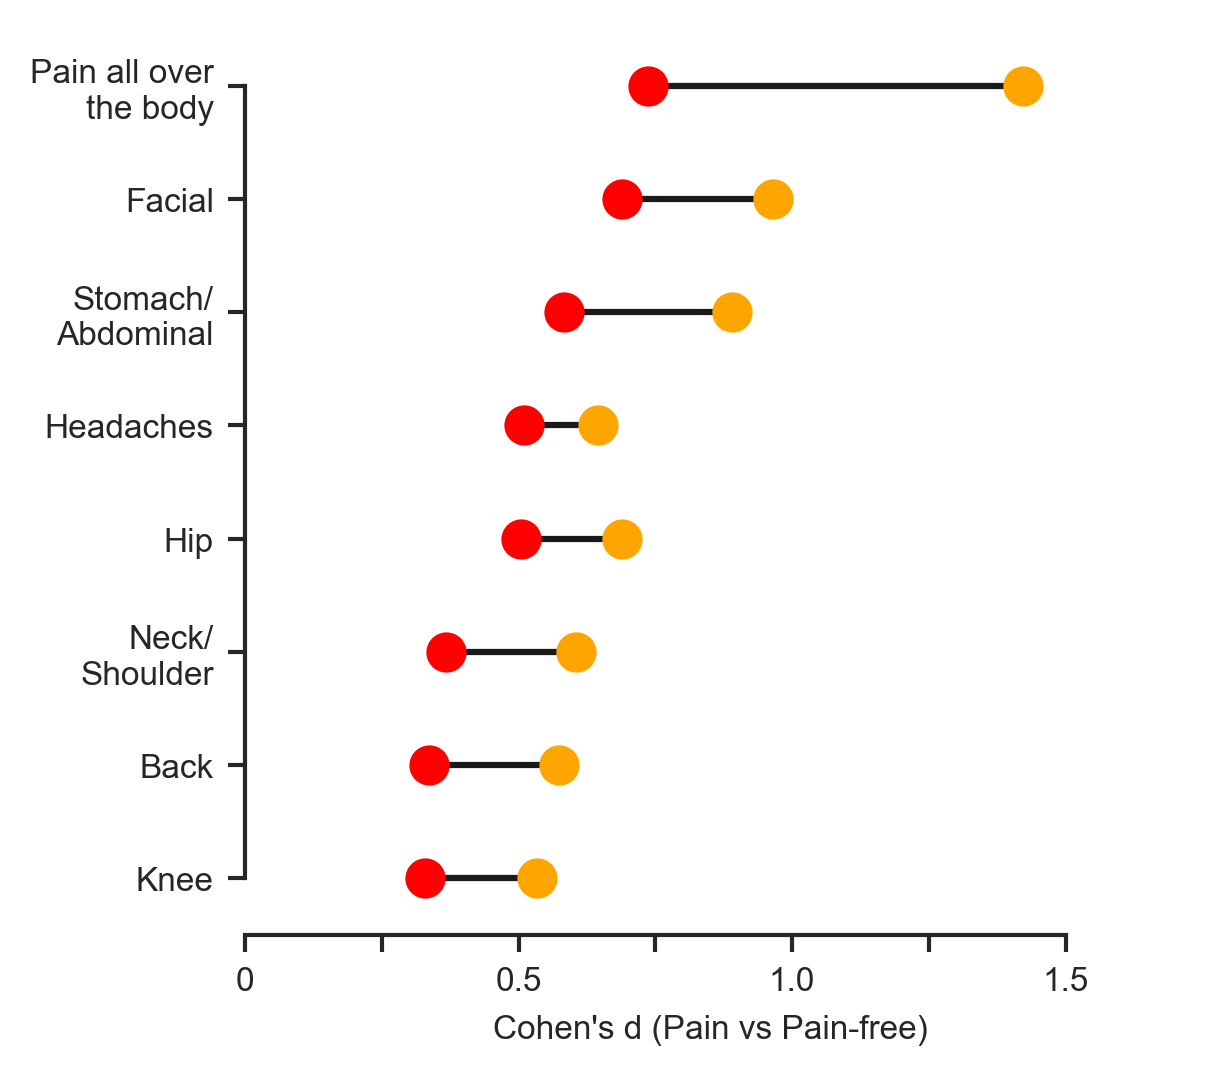

In [52]:
#### FIGURE B.2. Cohen's d across pain sites vs pain-free in the risk score ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(4, 4))
S = ['Knee','Back','Neck/\nShoulder','Hip','Headaches', 'Stomach/\nAbdominal', 'Facial', 'Pain all over\nthe body']
axs.errorbar(y = S, x = np.mean(Cohen, axis  = 0), xerr = [np.mean(Cohen, axis  = 0) - Cohen[1], np.mean(Cohen, axis  = 0) - Cohen[1]], fmt="", linestyle="", color = 'k', elinewidth = 1.5, zorder = 0)
axs.scatter(y = S, x = Cohen[0], s=75, color = 'Red'), axs.scatter(y = S, x = Cohen[1], s=75, color = 'orange')
axs.set_yticks(np.arange(0,8)), axs.set_yticklabels(S, fontsize = 8)
axs.set_ylim(-0.5, 7.5), axs.set_xlim(0, 1.7)
axs.spines[['top', 'right']].set_visible(False), axs.tick_params(left=True, bottom=True, width = 1, length = 4)
axs.spines['left'].set_bounds((0, 7)), axs.spines['bottom'].set_bounds((0, 1.5)), axs.spines[['bottom', 'left']].set_linewidth(1)
axs.set_xlabel("Cohen's d (Pain vs Pain-free)", fontsize = 8)
axs.set_xticks(np.arange(0, 1.75, 0.25)), axs.set_xticklabels(['0','','0.5','','1.0','','1.5'], fontsize = 8)

In [53]:
# Computing AUC-ROC for these comparisons
AUCROC = np.zeros((2,8))
df = preproc_UKB_Test[CP_Sites + AP_Sites + ['NoPainLastMonth_T0', 'PLS']]
for s in range(8):
    AP_gr, CP_gr = df[(df.NoPainLastMonth_T0==1) | (df[AP_Sites[s]]==1)], df[(df.NoPainLastMonth_T0==1) | (df[CP_Sites[s]]==1)]
    AUCROC[0,s], AUCROC[1,s] = metrics.roc_auc_score(y_true = AP_gr[AP_Sites[s]], y_score = AP_gr.PLS), metrics.roc_auc_score(y_true = CP_gr[CP_Sites[s]], y_score = CP_gr.PLS)


([Text(0, 0.5, 'Pain all over\nthe body'),
  Text(0, 1.5, 'Facial'),
  Text(0, 2.5, 'Stomach/\nAbdominal'),
  Text(0, 3.5, 'Headaches'),
  Text(0, 4.5, 'Hip'),
  Text(0, 5.5, 'Neck/\nShoulder'),
  Text(0, 6.5, 'Back'),
  Text(0, 7.5, 'Knee')],
 [Text(0.5, 0, 'Acute'), Text(1.5, 0, 'Chronic')])

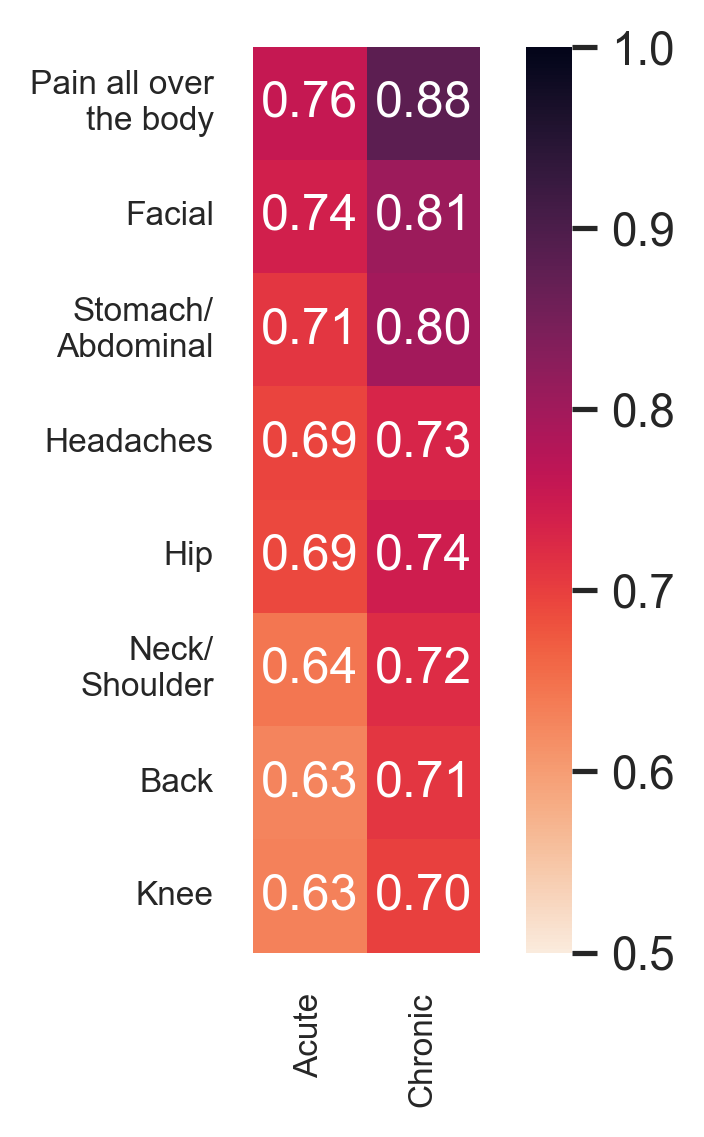

In [54]:
#### FIGURE B.3. Heatmap of all the AUCROC. ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(4, 4))
sns.heatmap(ax = axs, data = AUCROC.T[::-1], annot = True, fmt=".2f", square = True, cmap = 'rocket_r', yticklabels=True, vmin = 0.5, vmax = 1.0, cbar = True)
axs.set_yticklabels(S[::-1], rotation = 0, fontsize = 8), axs.set_xticklabels(['Acute', 'Chronic'], rotation = 90, fontsize = 8)

In [55]:
#### Obtain Non-Cancer Illnesses ####
NCI = pd.read_csv(Folder + '1_UKB_NonCancer_Illness.csv') #Script to obtain the file will be uploaded.
NCI = NCI.set_index('Unnamed: 0')
Coding_NCI = pd.read_csv(Folder + 'coding6.tsv', sep = '\t')
Coding_NCI = Coding_NCI[(Coding_NCI.coding!=-1) & (Coding_NCI.coding!=99999)]

In [56]:
# Filter columns, make sure that each diagnoses is present once, and add eids to merge the files
NCI_Test = NCI[NCI.filter(like = '_T0').columns.tolist()]
NCI_Test = pd.DataFrame(data = np.where(NCI_Test > 0, 1, NCI_Test), columns = NCI_Test.columns)
NCI_Test['eid'] = NCI.eid
NCI_Test = NCI_Test[NCI_Test.eid.isin(preproc_UKB_Test.eid)].reset_index(drop = True)

In [57]:
# Create a file of Diagnoses
NCI_Test['NCI_Free_T0'] = np.where(NCI_Test.drop(columns = 'eid').sum(axis = 1) > 0, 0, 1) #Compute NCI-Free for those reporting no NCI.
Z1 = ['NCI_Free_T0', 'NCI_cervical spondylosis_T0', 'NCI_spine arthritis/spondylitis_T0','NCI_disc degeneration_T0', 'NCI_fibromyalgia_T0','NCI_spinal injury_T0', 'NCI_headaches (not migraine)_T0', 'NCI_irritable bowel syndrome_T0','NCI_osteoarthritis_T0', 'NCI_migraine_T0','NCI_rheumatoid arthritis_T0', 'NCI_emphysema/chronic bronchitis_T0', 'NCI_trapped nerve/compressed nerve_T0','NCI_chronic fatigue syndrome_T0','NCI_gastric/stomach ulcers_T0','NCI_hiatus hernia_T0','NCI_endometriosis_T0','NCI_chronic obstructive airways disease/copd_T0', 'NCI_angina_T0','NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0','NCI_carpal tunnel syndrome_T0', 'NCI_pulmonary embolism +/- dvt_T0', 'NCI_stroke_T0','NCI_heart attack/myocardial infarction_T0','NCI_diabetes_T0','NCI_multiple sclerosis_T0']
Z2 = ['Free','Cervical Spondylosis','Spinal Spondylitis','Disc Degeneration','Fibromyalgia','Spinal Injury','Non-Migraine Headaches','Irritable Bowel Synd.','Osteoarthritis','Migraine','Rheumatoid Arthritis','Chronic Bronchitis','Compressed Nerve','Chronic Fatigue Synd.','Gastric Ulcers','Hiatus Hernia','Endometriosis','Chronic Obstructive\nPulmonary Disease','Angina','Gastro-Oesophageal\nReflux','Carpal Tunnel Synd.','Pulmonary Embolism ','Stroke','Myocardial Infarction','Diabetes','Multiple Sclerosis']
rename = dict(zip(Z1, Z2))
DF = NCI_Test[Z1].rename(columns = rename)

In [58]:
# Compute boostrap interval using scipy for cohen's d
# Compute AUC-ROC score as well
pd.options.mode.chained_assignment = None  # Use an approach of index that saves memory (faster) but is not reommended
Cohen_BS, AUCROC_NCI = np.zeros((3, len(Z2)-1)), np.zeros((1, len(Z2)-1))
NCI_F = preproc_UKB_Test[DF['Free']==1]
NCI_F['one'] = 0
rng = np.random.default_rng()
for n, nci in enumerate(Z2[1:]):
    Filter = DF[nci]==1
    Group = preproc_UKB_Test[Filter]
    Group['one'] = 1
    Cohen_BS[0, n] = cohen_d(Group.PLS, NCI_F.PLS) #First row is the cohen's d estimated
    BS = stats.bootstrap((Group.PLS, NCI_F.PLS), cohen_d, confidence_level=0.95,method='percentile',random_state=rng,n_resamples=10000,vectorized = False)
    Cohen_BS[1, n], Cohen_BS[2, n] = BS.confidence_interval[0], BS.confidence_interval[1]
    Gr = Group.append(NCI_F)
    AUCROC_NCI[0,n] = metrics.roc_auc_score(y_true = Gr['one'], y_score = Gr.PLS)

In [59]:
# Results into dataframe
Cohen_BS = pd.DataFrame(Cohen_BS, columns = Z2[1:], index = ['value', 'low', 'high']).T.sort_values(by = 'value', ascending = False).T
AUCROC_NCI = pd.Series(AUCROC_NCI[0], name = 'AUC-ROC', index = Z2[1:])[Cohen_BS.columns].T

Text(0.5, 1.0, 'AUC-ROC (NCI vs NCI-free)')

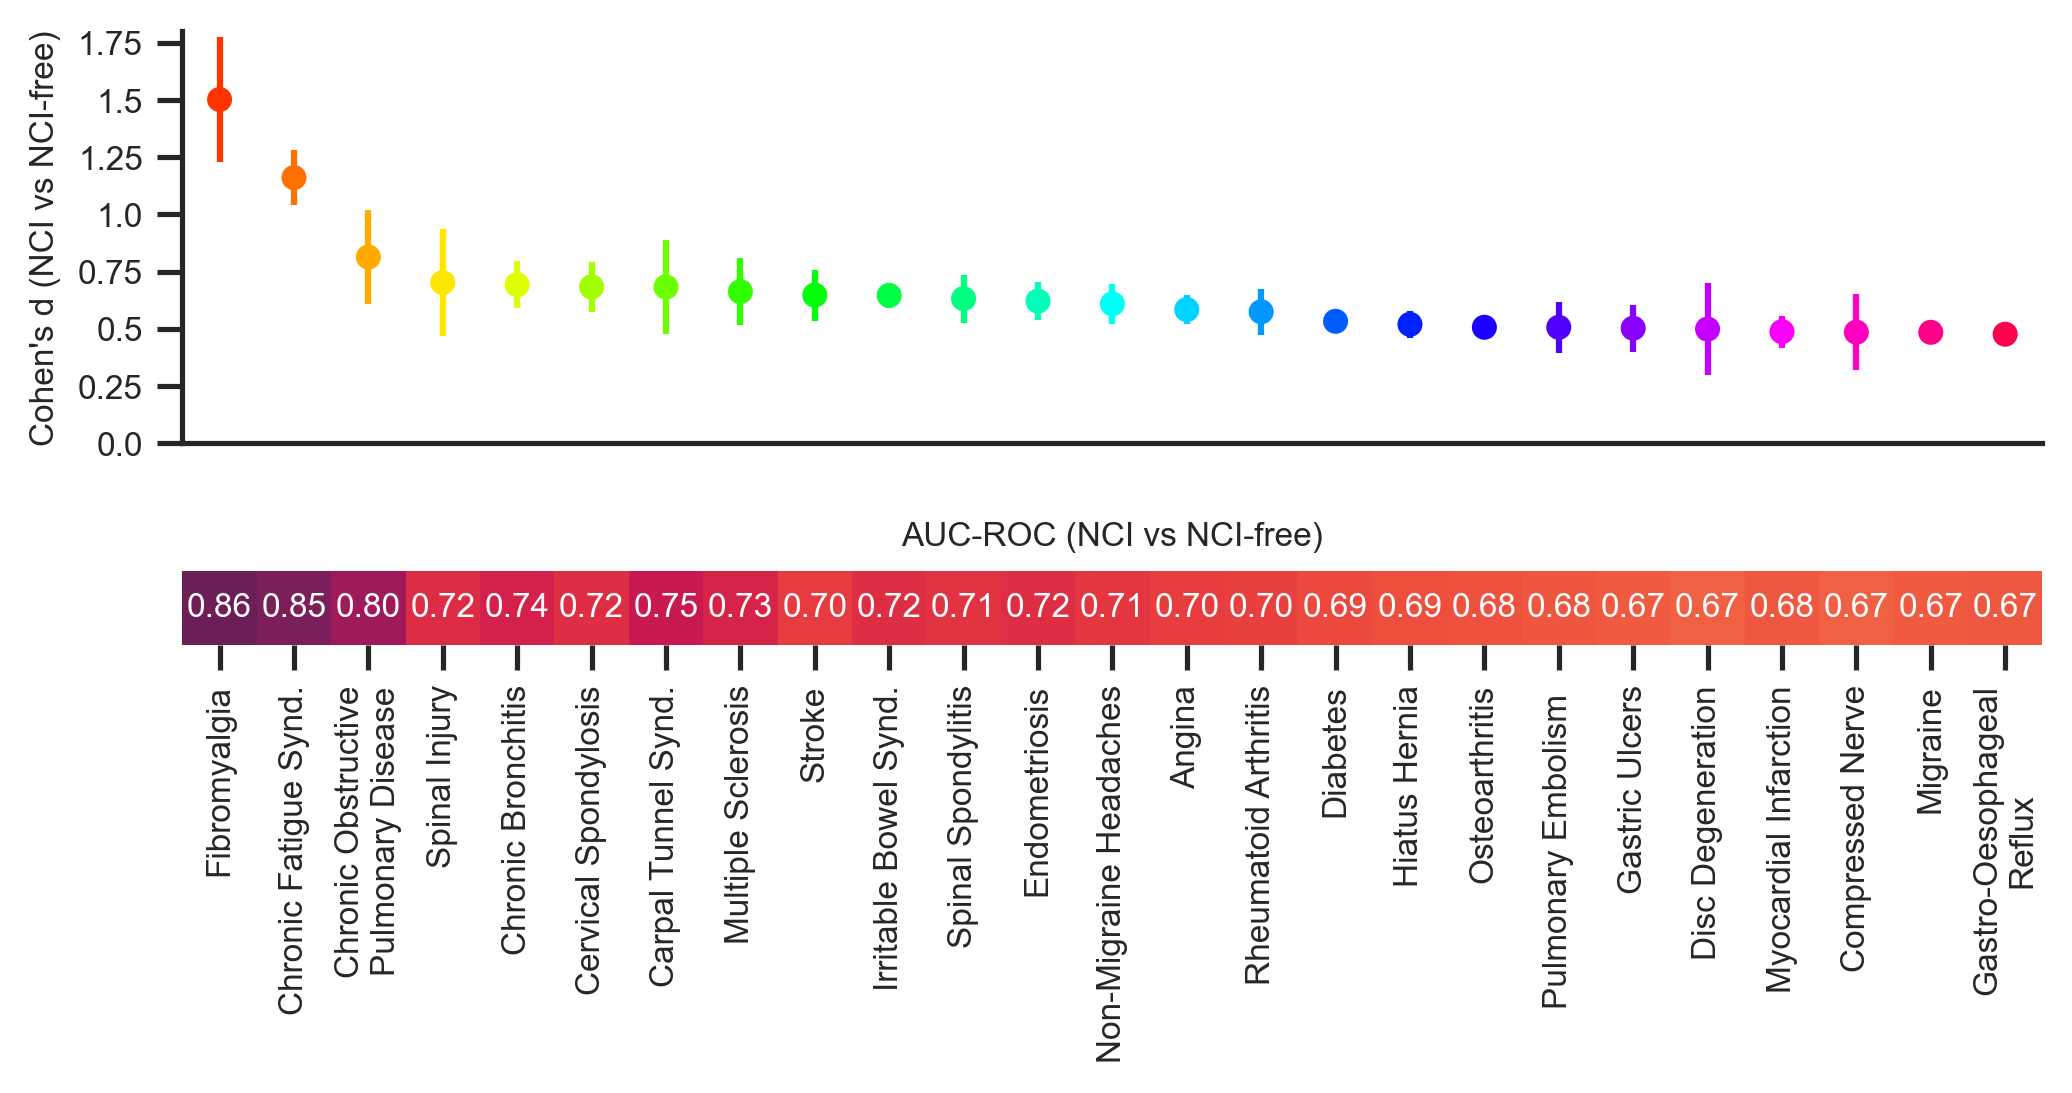

In [60]:
#### FIGURE B4. Risk score across NCIs ####
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), gridspec_kw={'height_ratios': [1,0.5]})
#Cohen's d bootstraps confidence intervals
axs[0].scatter(y = Cohen_BS.T.value, x = np.arange(25), s=25, color = sns.color_palette('hsv', 25))
axs[0].errorbar(x = np.arange(25), y = Cohen_BS.T.value, yerr = [Cohen_BS.T.value - Cohen_BS.T.low, Cohen_BS.T.value - Cohen_BS.T.low], fmt="", linestyle="", ecolor = sns.color_palette('hsv', 25), elinewidth = 1.5, zorder = 0)
axs[0].set_xlim(-0.5, 24.5), axs[0].set_ylim(0, 1.8)
axs[0].spines[['right', 'top']].set_visible(False), axs[0].tick_params(left=True)
axs[0].set_ylabel("Cohen's d (NCI vs NCI-free)", fontsize = 8), axs[0].set_yticks(np.arange(0, 2, 0.25))
axs[0].set_xticks(np.arange(25)), axs[0].set_xticklabels([]), axs[0].set_yticklabels(np.arange(0,2, 0.25), fontsize = 8)
# Heatmap of AUC-ROC
sns.heatmap(ax = axs[1], data = [AUCROC_NCI], annot = True, fmt=".2f", square = True, cmap = 'rocket_r', yticklabels=False, vmin = 0.5, vmax = 1.0, cbar = False, annot_kws={"fontsize":8})
axs[1].set_xticklabels(Cohen_BS.columns, rotation = 90, fontsize = 8)
axs[1].tick_params(bottom=True), 
axs[1].set_title('AUC-ROC (NCI vs NCI-free)', fontsize = 8)